# Angle Recovery with Perfect Distances

In this phase we will try to do angle recovery assuming we know the prefect distances.

The optimization equation looks like this:
\begin{equation}
\label{eq:phase1}
{\{\hat{q_i}\}_{i=1}^N} = \operatorname*{arg\,min}_{\{\hat{q}_i\}_{i=1}^N} \sum_{i,j} \left| d_q(q_i, q_j) - d_q(\hat{q_i}, \hat{q_j}) \right|^2
\end{equation}

We start by random uniform distribution of angle triplets corresponding to the quaternion values $\hat{q_i}$ and $\hat{q_j}$ and we want to see if during the optimization we manage to estimate the true quaternions $q_i$ and $q_j$.


## Content

In [52]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
from IPython.display import Image
import ipyvolume as ipv
import tensorflow as tf

import sys
sys.path.append("../..") 
from cryoem.plots import (plot_angles_count, plot_euclidean_space, save_space_plot,
                        plot_selected_angles_with_3rd_angle_magnitude, 
                        plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, 
                        plot_rays, plot_images, plot_angles_with_3rd_angle_magnitude, plot_distances_count)
from cryoem.conversions import d_q, quaternion2euler, euler2quaternion, distance_difference
from cryoem.angle_alignment import training_angle_alignment,update_quaternion
from cryoem.angle_recovery import train_angle_recovery
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1144800446685523078
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12656486951088216633
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6686833596919876467
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 8927090343117224124
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:db:00.0, compute capability: 3.5"
]


---

## 1. Symmetric Protein (5A1A)

Data used:
- Protein: 5a1a (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5a1a.pdb1-500.jpg)

---

# 1.2. Data Preparation

In [56]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage0.9,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


#### Projections

In [57]:
projections = data['Projections']

#### True Angles

(5000, 3)


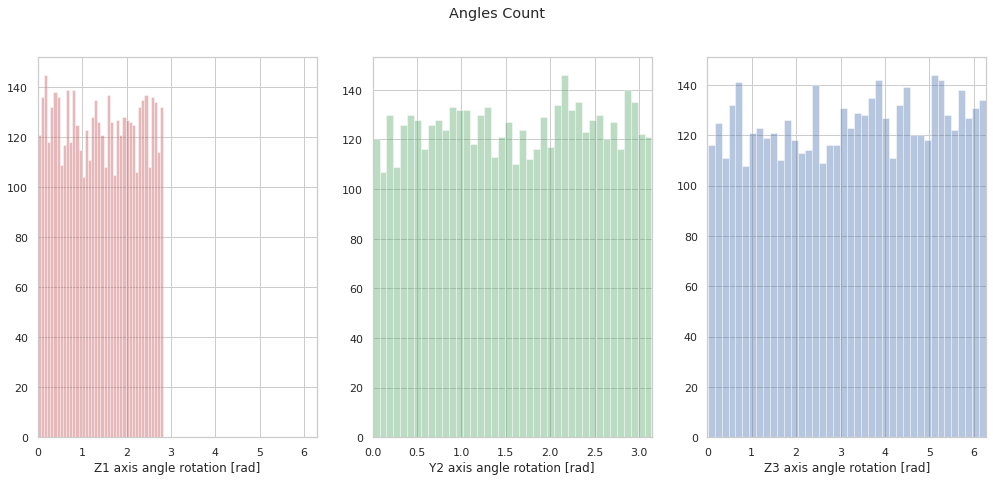

In [58]:
angles_true = np.array(data['Angles'])
print(angles_true.shape)
plot_angles_count(angles_true)

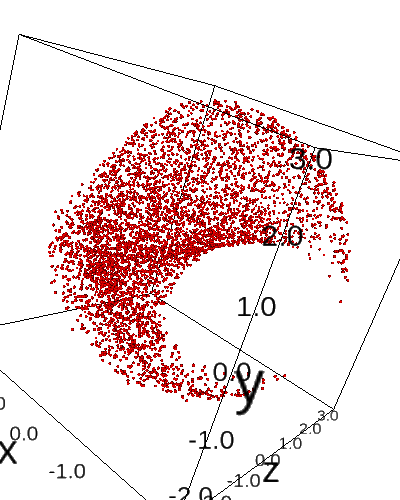

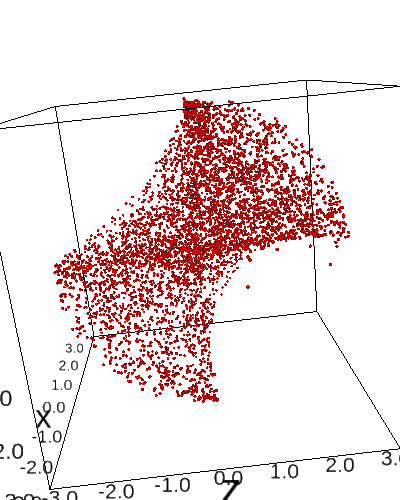

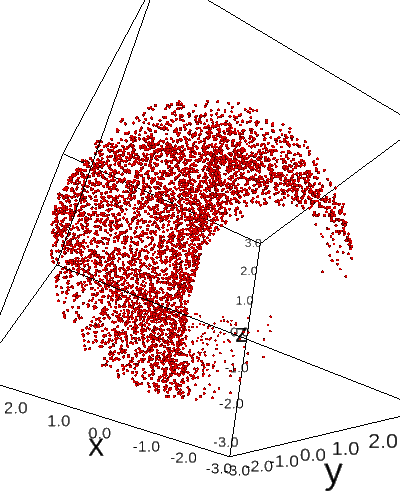

In [15]:
arr_true = R.from_euler('zyz', angles_true).as_rotvec()
a = arr_true

ipv.figure()
ipv.scatter(a[:,0], a[:,1], a[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-np.pi, np.pi);ipv.ylim(-np.pi, np.pi);ipv.zlim(-np.pi, np.pi);
ipv.show()

In [24]:
ipv.screenshot()

Output()

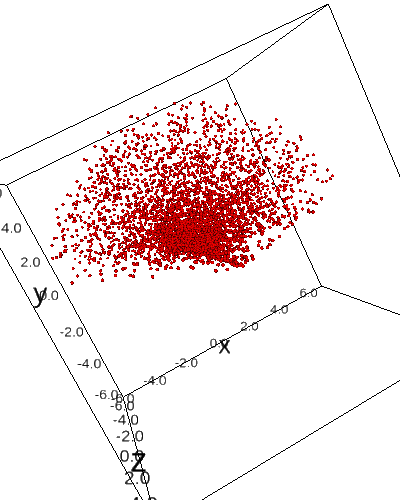

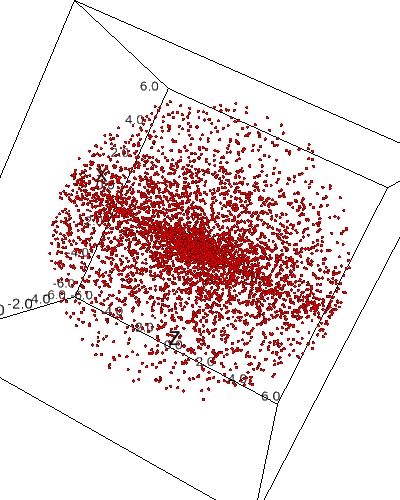

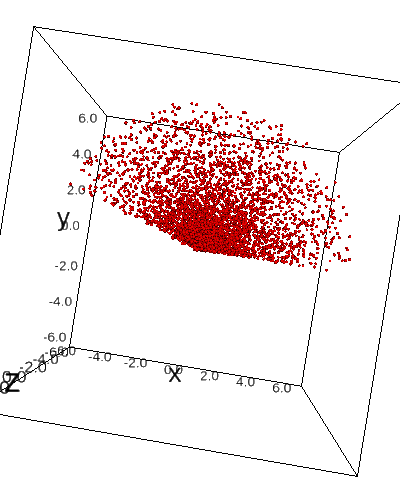

In [60]:
z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

ipv.clear()
x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)


ipv.scatter(x, y, z, marker="sphere", color="red", size=1)
ipv.xlim(-2*np.pi, 2*np.pi);ipv.ylim(-2*np.pi, 2*np.pi);ipv.zlim(-2*np.pi, 2*np.pi);
ipv.show()


In [63]:
ipv.screenshot()

Output()

---

# 1.3. Experiments

## 1.3.1. Angle Recovery: Perfect Distance

#### dP/dQ plot

In [28]:
def d_p(in1, in2):
    return d_q(in1, in2)

In [29]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

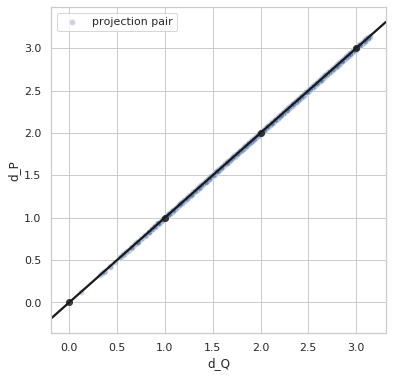

<Figure size 432x288 with 0 Axes>

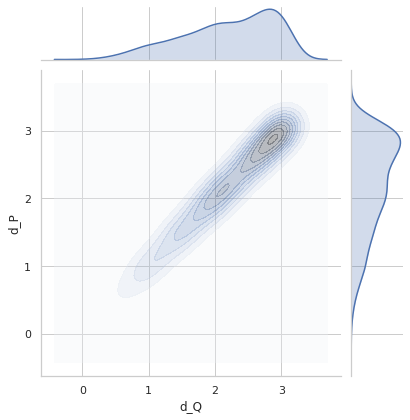

In [30]:
plot_dP_dQ(dP_values, dQ_values);
plot_dP_dQ_density(dP_values, dQ_values);

In [31]:
# variance
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.0

#### Angle Recovery

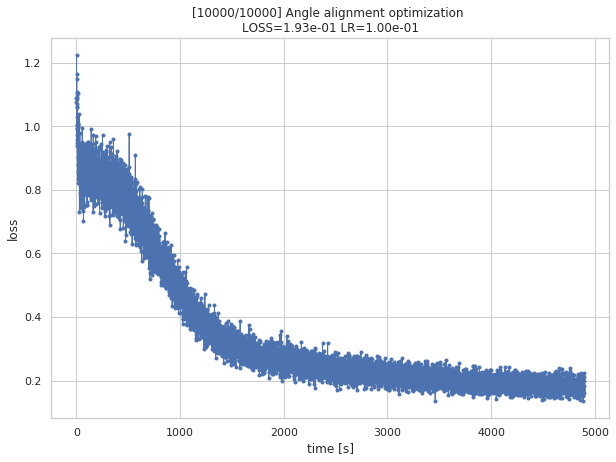

Shape of projections: (5000, 4)step 1000/10000 (516s): loss = 8.39e-01
step 2000/10000 (1016s): loss = 5.10e-01
step 3000/10000 (1516s): loss = 3.61e-01
step 4000/10000 (2012s): loss = 2.71e-01
step 5000/10000 (2485s): loss = 2.19e-01
step 6000/10000 (2943s): loss = 2.31e-01
step 7000/10000 (3397s): loss = 1.87e-01
step 8000/10000 (3882s): loss = 1.83e-01
step 9000/10000 (4388s): loss = 2.17e-01
step 10000/10000 (4893s): loss = 2.10e-01



In [33]:
losses, q_predicted, arrp = train_angle_recovery(steps=10000, 
                                 batch_size=512, 
                                 in_data=angles_true, 
                                 distance_fn=d_p, 
                                 learning_rate=0.1, 
                                 optimization=True)

In [52]:
%matplotlib inline
from scipy.spatial.transform import Rotation as R

arr2 = R.from_euler('zyz', angles_true).as_rotvec()

ipv.figure()
s = ipv.scatter(arrp[:, :,0], arrp[:, :,1], arrp[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=1)
ipv.show()

In [51]:
ipv.screenshot()

Output()

In [40]:
# q_save = np.zeros((len(q_predicted),4))
# for i, q in enumerate(q_predicted):
#     q_save[i] = q.numpy()
                    
# np.save("data/5a1a/predicted_quaternions.npy2", q_save)

In [38]:
# Image(filename='../3-reconstruction/data/5a1a_projections_and_angles_predicted.png')

## Angle Alignment

In [55]:
def angles_transpose(angles):
    angles[:,[0, 2]] = angles[:,[2, 0]]
    angles *= -1
    return angles

In [56]:
qp = np.load("data/5a1a/predicted_quaternions2.npy")

transposed = False
ap = quaternion2euler(qp)
ap = angles_transpose(ap.numpy())

np.save("data/5a1a/predicted_angles.npy", ap)

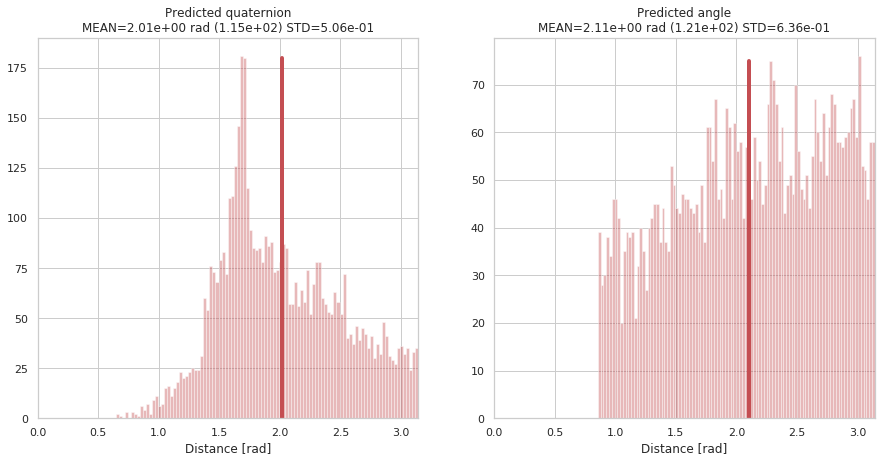

In [57]:
# check: both plots should be the same (if transposed=False)
fig, axs = plt.subplots(1, 2, figsize=(15,7))
d2 = d_q(euler2quaternion(angles_true), qp)
axs[0].set_xlim(0, np.pi)
axs[0].set_title(f"Predicted quaternion\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
s = sns.distplot(d2, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[0].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

d3 = d_q(euler2quaternion(angles_true), euler2quaternion(ap))
axs[1].set_xlim(0, np.pi)
axs[1].set_title(f"Predicted angle\nMEAN={np.mean(d3):.2e} rad ({np.degrees(np.mean(d3)):.2e}) STD={np.std(d3):.2e}")
s = sns.distplot(d3, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[1].plot([np.mean(d3)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

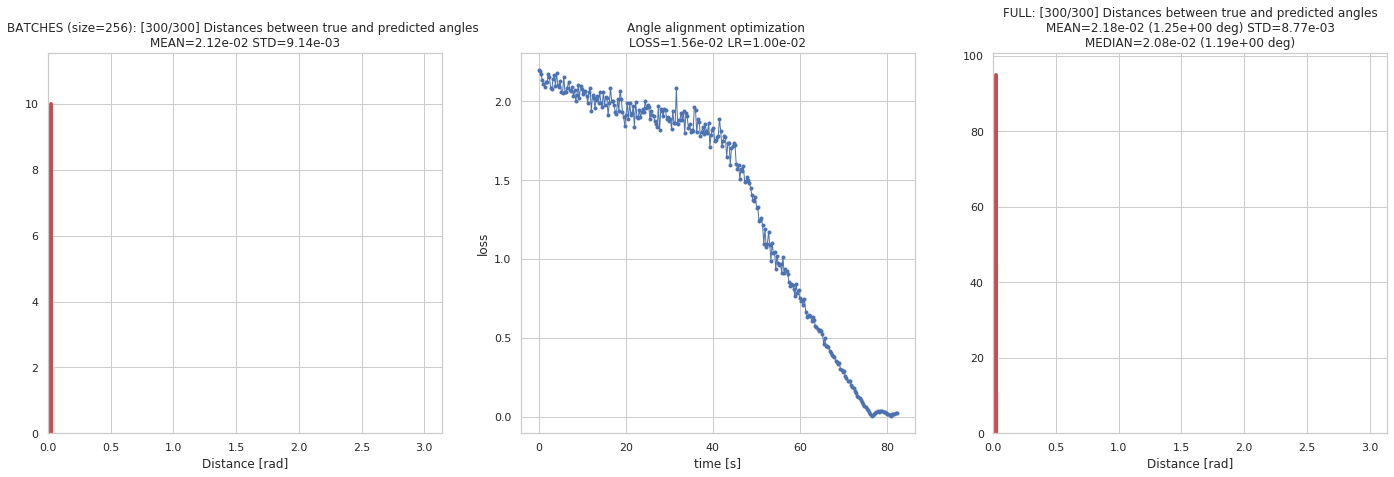

step 30/300 (9s): loss = 2.12e+00
step 60/300 (17s): loss = 2.03e+00
step 90/300 (26s): loss = 1.95e+00
step 120/300 (34s): loss = 1.91e+00
step 150/300 (43s): loss = 1.84e+00
step 180/300 (51s): loss = 1.64e+00
step 210/300 (59s): loss = 1.09e+00
step 240/300 (67s): loss = 6.75e-01
step 270/300 (76s): loss = 2.86e-01
step 300/300 (84s): loss = 3.07e-02



In [66]:
m, rotation, loss, arr = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=300, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap)

In [67]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([7.75002656, 0.3007453 , 6.15445275, 0.98073965, 3.15953732,
        5.46325849]),
 0.02073006861499844)

In [68]:
arr = np.array(arr)

In [69]:
from scipy.spatial.transform import Rotation as R

arr2 = R.from_euler('zyz', angles_true).as_rotvec()

ipv.figure()
s = ipv.scatter(arr[:, :,0], arr[:, :,1], arr[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=200)
ipv.show()

In [50]:
qpn = euler2quaternion(ap)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted = quaternion2euler(qpa).numpy()

np.save("data/5a1a/predicted_angles_updated.npy", angles_predicted)

In [30]:
# Image(filename='../3-reconstruction/data/5a1a_projections_and_angles_predicted_updated.png')

---

# 2. Asymmetric Protein (5J0N)

Data used:
- Protein: 5j0n (asymmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

---

# 2.2. Data Preparation

In [4]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


#### Projections

In [5]:
projections = data['Projections']

#### True Angles

(5000, 3)


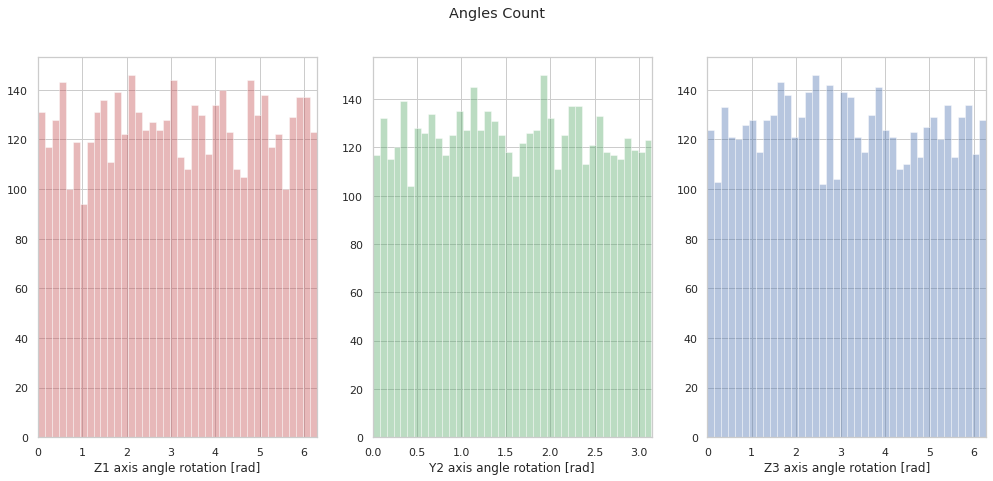

In [6]:
angles_true = np.array(data['Angles'])
print(angles_true.shape)
plot_angles_count(angles_true)

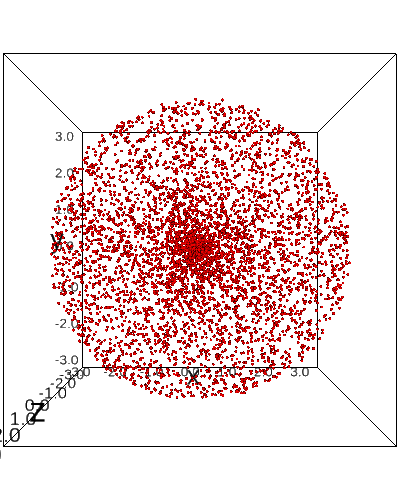

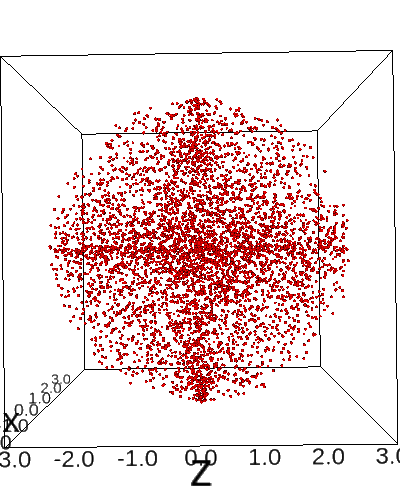

In [7]:
arr_true = R.from_euler('zyz', angles_true).as_rotvec()
a = arr_true

ipv.figure()
ipv.scatter(a[:,0], a[:,1], a[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-np.pi, np.pi);ipv.ylim(-np.pi, np.pi);ipv.zlim(-np.pi, np.pi);
ipv.show()

In [9]:
ipv.screenshot()

Output()

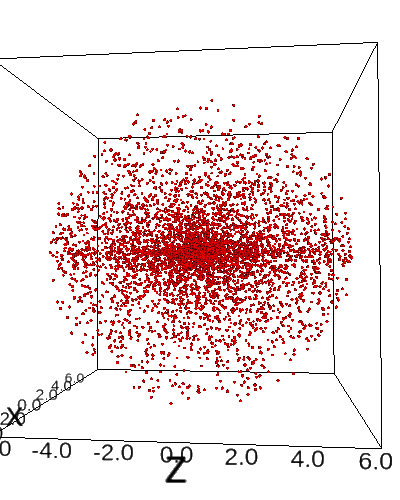

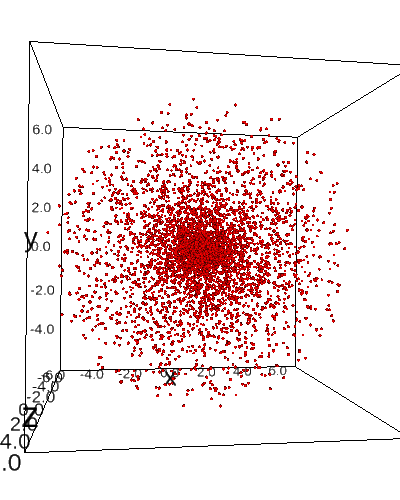

In [10]:
z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

ipv.clear()
x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)

ipv.scatter(x, y, z, marker="sphere", color="red", size=1)
ipv.show()

In [12]:
ipv.screenshot()

Output()

---

# 2.3. Experiments

## 2.3.1. Angle Recovery: Perfect Distance

#### dP/dQ plot

In [7]:
def d_p(in1, in2):
    return d_q(in1, in2)

In [8]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

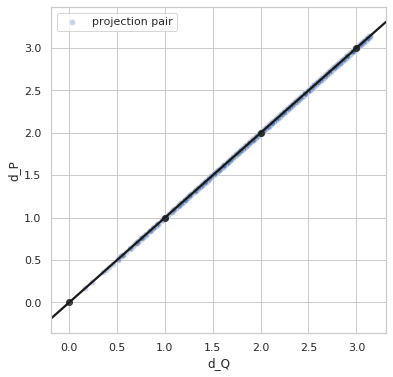

<Figure size 432x288 with 0 Axes>

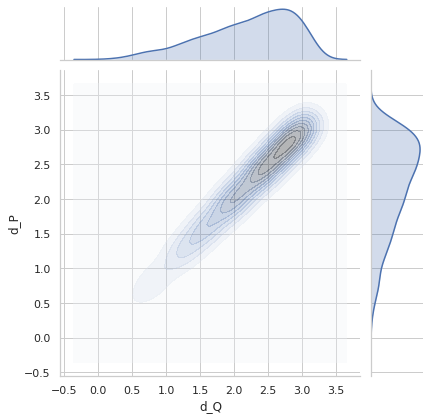

In [9]:
plot_dP_dQ(dP_values, dQ_values);
plot_dP_dQ_density(dP_values, dQ_values);

In [10]:
# variance
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.0

In [11]:
def loss(dQ_values, dP_values):
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(tf.pow((dQ_values - dP_values), 2))

In [12]:
loss(dQ_values, dP_values).numpy()

0.0

## Angle Recovery

In [13]:
# from cryoem.angle_recovery import angles_transpose

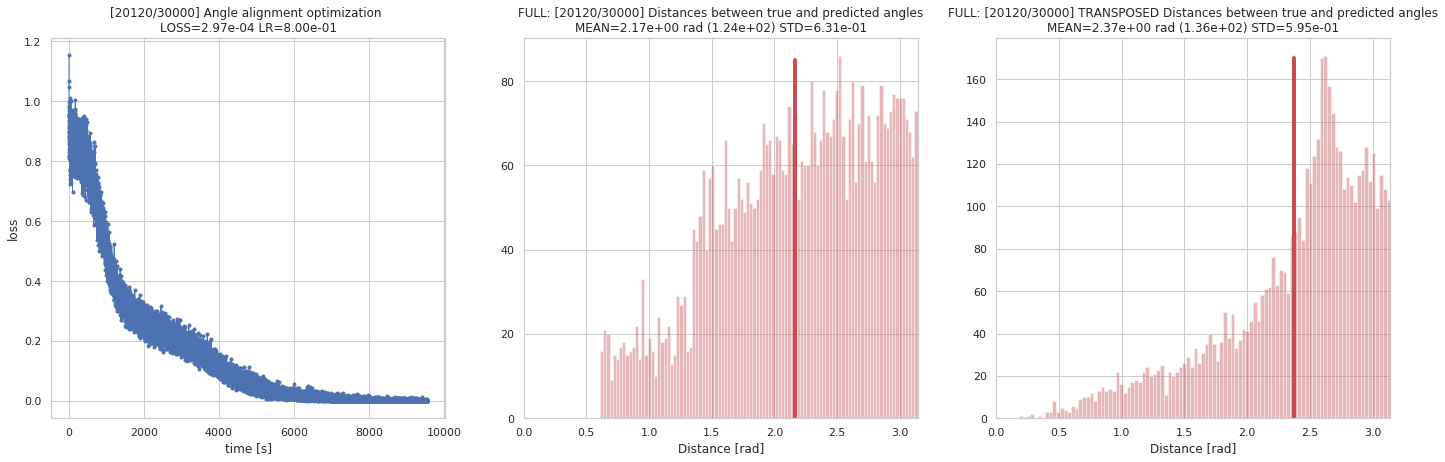

Shape of projections: (5000, 4)step 3000/30000 (1369s): loss = 3.63e-01
step 6000/30000 (2723s): loss = 1.81e-01
step 9000/30000 (4116s): loss = 1.06e-01
step 12000/30000 (5578s): loss = 2.10e-02
step 15000/30000 (7048s): loss = 2.47e-03
step 18000/30000 (8508s): loss = 2.44e-04
step 20120/30000 (9549s): loss = 1.27e-04



In [13]:
q_predicted, losses, q_all = train_angle_recovery(steps=30000, 
                                                   batch_size=512, 
                                                   in_data=angles_true, 
                                                   distance_fn=d_p, 
                                                   learning_rate=0.8, #0.1, 
                                                   angles_true=angles_true,
                                                   optimization=True)

In [14]:
angles_predicted_all = np.zeros((*q_all.shape[0:2], 3))
for i, q in enumerate(q_all):
    angles_predicted_all[i, :] = R.from_quat(q).as_euler("zyz")

In [16]:
# PREDICTED ANGLES ITERATION    
xyz = np.zeros(angles_predicted_all.shape)
for i, a in enumerate(angles_predicted_all):
    z0, y1, z1 = a[:,0], a[:,1], a[:,2]
    x = z1*np.sin(y1)*np.cos(z0)
    y = z1*np.sin(y1)*np.sin(z0)
    z = z1*np.cos(y1)
    xyz[i,:,:] = np.array([x, y, z]).T
    
# TRUE ANGLES
xyz_true = np.zeros(angles_true.shape)
z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)

xyz_true = np.array([x, y, z]).T

# # PREDICTED ANGLES
# xyz_predicted = np.zeros(angles_predicted.shape)
# z0, y1, z1 = angles_predicted[:,0], angles_predicted[:,1], angles_predicted[:,2]

# x = z1*np.sin(y1)*np.cos(z0)
# y = z1*np.sin(y1)*np.sin(z0)
# z = z1*np.cos(y1)

# xyz_predicted = np.array([x, y, z]).T

In [18]:
# ipv.figure()
# ipv.scatter(xyz_predicted[:,0], xyz_predicted[:,1], xyz_predicted[:,2], marker="sphere", color="blue", size=1)
# ipv.scatter(xyz_true[:, 0], xyz_true[:, 1], xyz_true[:, 2], marker="sphere", color="red", size=1)
# ipv.xlim(-2*np.pi, 2*np.pi);ipv.ylim(-2*np.pi, 2*np.pi);ipv.zlim(-2*np.pi, 2*np.pi);
# # ipv.animation_control(s, interval=50)
# ipv.show()

# Polar Plot

In [22]:
ipv.figure()
s = ipv.scatter(xyz[:, :,0], xyz[:, :,1], xyz[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(xyz_true[:,0], xyz_true[:,1], xyz_true[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-2*np.pi, 2*np.pi);ipv.ylim(-2*np.pi, 2*np.pi);ipv.zlim(-2*np.pi, 2*np.pi);
ipv.animation_control(s, interval=1)
ipv.show()

# Rot Vector

In [20]:
arr2 = R.from_euler('zyz', angles_true).as_rotvec()
arr3 = np.zeros((len(angles_predicted_all), *arr2.shape))
for i, a in enumerate(angles_predicted_all):
    arr3[i,:] = R.from_euler('zyz', a).as_rotvec()

ipv.figure()
s = ipv.scatter(arr3[:, :,0], arr3[:, :,1], arr3[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=1)
ipv.show()

In [23]:
np.save("data/5j0n/predicted_quaternions_full_losses.npy", losses)

In [25]:
np.save("data/5j0n/predicted_quaternions_full_iterations.npy", q_all)

In [26]:
q_save = np.zeros((len(q_predicted),4))
for i, q in enumerate(q_predicted):
    q_save[i] = q.numpy()
                    
np.save("data/5j0n/predicted_quaternions_full.npy", q_save)

In [29]:
# Image(filename='../3-reconstruction/data/5j0n_projections_and_angles_predicted.png')

# Angle Alignment

#### Prediction angles from previous phase that we want to align with true angles

In [28]:
def angles_transpose(angles):
    cols = [2, 1, 0]
    idx = np.empty_like(cols)
    idx[cols] = np.arange(len(cols))
    angles[:] = -angles[:, idx]
    return angles

In [30]:
quaternion_predicted = np.load("data/5j0n/predicted_quaternions_full.npy")

In [49]:
angles_predicted = quaternion2euler(quaternion_predicted).numpy()
np.save("data/5j0n/predicted_angles_full.npy", angles_predicted)

---

#### True angles

In [32]:
# angles_true = np.load("data/angles_true.npy")

#### Run the Optimization

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

In [35]:

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
import time
from IPython import display as IPyDisplay
from scipy.spatial.transform import Rotation as R


def euler6tomarix4d(a_R):

    xy, xz, xw, yz, yw, zw = tf.unstack(a_R, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = [[  cxy,  -sxy, [0.0], [0.0]], 
           [  sxy,   cxy, [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxy = tf.reshape(tf.convert_to_tensor(Rxy, dtype=tf.float64), (4, 4)) 
    
    Rxz = [[  cxz, [0.0],  -sxz, [0.0]],
           [[0.0], [1.0], [0.0], [0.0]],
           [  sxz, [0.0],   cxz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxz = tf.reshape(tf.convert_to_tensor(Rxz, dtype=tf.float64), (4, 4))
    
    Rxw = [[  cxw, [0.0], [0.0],  -sxw],
           [[0.0], [1.0], [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]], 
           [  sxw, [0.0], [0.0],  cxw]]
    Rxw = tf.reshape(tf.convert_to_tensor(Rxw, dtype=tf.float64), (4, 4))
    
    Ryz = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyz,  -syz, [0.0]],
           [[0.0],   syz,   cyz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Ryz = tf.reshape(tf.convert_to_tensor(Ryz, dtype=tf.float64), (4, 4))
    
    Ryw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyw, [0.0],  -syw],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0],   syw, [0.0],  cyw]]
    Ryw = tf.reshape(tf.convert_to_tensor(Ryw, dtype=tf.float64), (4, 4))
    
    Rzw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0], [1.0], [0.0], [0.0]], 
           [[0.0], [0.0],   czw,  -szw],
           [[0.0], [0.0],   szw,  czw]]
    Rzw = tf.reshape(tf.convert_to_tensor(Rzw, dtype=tf.float64), (4, 4))
  
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    # check if matrix is orthogonal: R^T @ R - I < 1e-5
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.subtract(tf.transpose(R) @ R, tf.eye(4, 4, dtype=tf.float64))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
        
    return R


def update_quaternion(m, a_R, q_predicted):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return q_predicted_rotated

def loss_alignment(m, a_R, q_predicted, q_true):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(m, a_R, q_predicted, q_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, q_predicted, q_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(m, steps, batch_size, learning_rate, angles_true, angles_predicted):
    
    collect_data = []

    optimizer = Adam(learning_rate=learning_rate)

    time_start = time.time()

    report = ""

    losses = np.empty(steps)
    angles_predicted = tf.convert_to_tensor(angles_predicted)

    euler = tf.random.uniform([6], 0, 2*np.pi, dtype=tf.float64) #np.zeros(6, dtype=np.float64)
    a_R = [tf.Variable(euler)]

    q_predicted = euler2quaternion(angles_predicted)
    q_true = euler2quaternion(angles_true)

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(range(len(angles_predicted)), size=batch_size))

        # Compute distances between projections
        qt = [q_true[i]      for i in idx]
        qp = [q_predicted[i] for i in idx]

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient_alignment(m, a_R, qp, qt)
        optimizer.apply_gradients(zip(gradients, a_R))

        update_lr = 300
        if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
            learning_rate *= 0.1

        # Visualize progress periodically
        if step % 10 == 0:
            qu = update_quaternion(m, a_R, q_predicted)

            collect_data.append(qu.numpy())

            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            fig, axs = plt.subplots(1, 3, figsize=(24,7))

            # Distance count subplot (batches)
            qpr = update_quaternion(m, a_R, qp)
            d1 = d_q(qpr, qt)
            axs[0].set_xlim(0, np.pi)
            #axs[0].set_ylim(0, batch_size)
            axs[0].set_title(f"BATCHES (size={len(qp)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
            s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            # Optimization loss subplot
            axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
            axs[1].set_xlabel('time [s]')
            axs[1].set_ylabel('loss');
            axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

            # Distance count subplot (full)
            q_predicted_rot = update_quaternion(m, a_R, q_predicted)
            d2 = d_q(q_predicted_rot, q_true)
            axs[2].set_xlim(0, np.pi)
            # axs[2].set_ylim(0, len(angles_true))
            axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
            s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)


            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(.1)


        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

        if step >= 101 and np.mean(losses[step-101:step-1]) < 1e-3:
            break;

    print(report)
    print("---")
    return m, a_R, losses, np.array(collect_data)

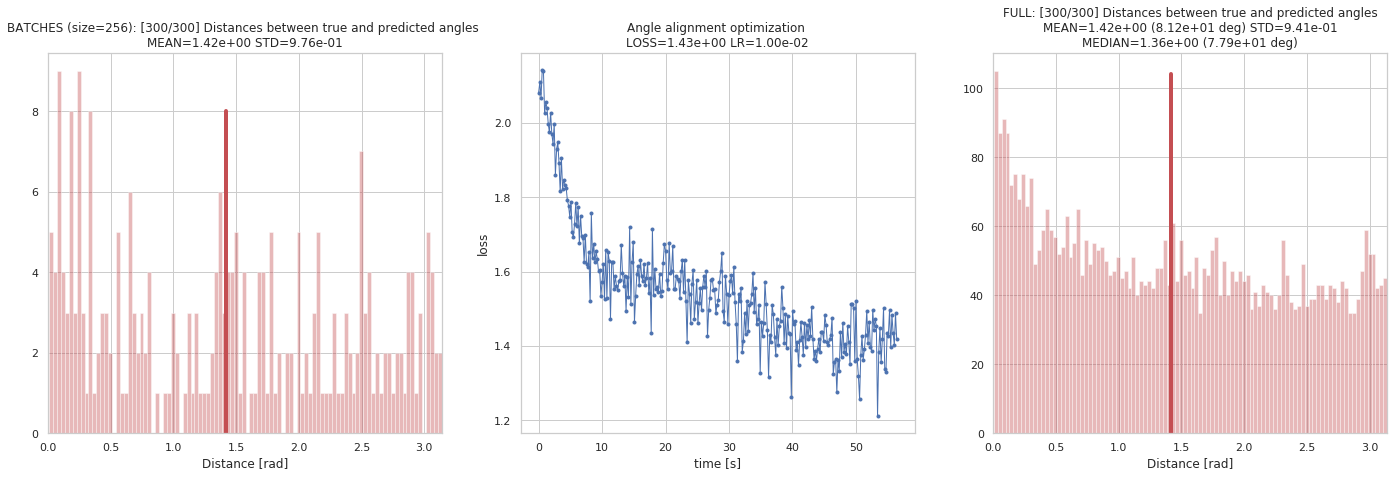

step 30/300 (6s): loss = 1.93e+00
step 60/300 (12s): loss = 1.65e+00
step 90/300 (18s): loss = 1.58e+00
step 120/300 (23s): loss = 1.59e+00
step 150/300 (29s): loss = 1.54e+00
step 180/300 (35s): loss = 1.52e+00
step 210/300 (41s): loss = 1.46e+00
step 240/300 (46s): loss = 1.42e+00
step 270/300 (52s): loss = 1.40e+00
step 300/300 (58s): loss = 1.42e+00

---


In [36]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=300, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true, 
                                                 angles_predicted=angles_predicted)

In [37]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([ 2.8004993 ,  2.73118239,  0.0065255 ,  2.02984487, -0.10063999,
         4.63284863]),
 1.4177897084364184)

In [38]:
collect_data.shape

(30, 5000, 4)

In [39]:
np.max(angles_true)

6.282679945774219

In [40]:
np.max(angles_predicted)

3.1411004859993654

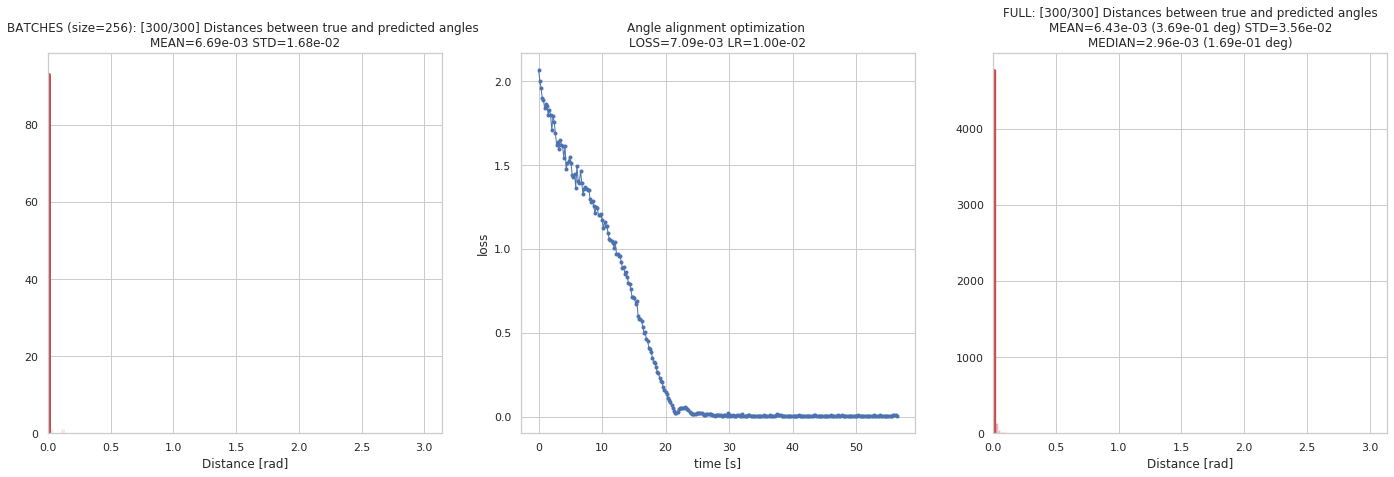

step 30/300 (6s): loss = 1.71e+00
step 60/300 (12s): loss = 1.29e+00
step 90/300 (17s): loss = 8.11e-01
step 120/300 (23s): loss = 2.01e-01
step 150/300 (29s): loss = 2.33e-02
step 180/300 (35s): loss = 8.03e-03
step 210/300 (40s): loss = 6.90e-03
step 240/300 (46s): loss = 6.41e-03
step 270/300 (52s): loss = 6.41e-03
step 300/300 (57s): loss = 6.42e-03

---


In [41]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[-1.0, 1.0, 1.0, 1.0],
                                                 steps=300, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true, 
                                                 angles_predicted=angles_predicted)

# Polar Plot

In [42]:
# # PREDICTED ANGLES ITERATION
# angles_predicted_all = np.zeros((*collect_data.shape[0:2], 3))
# for i, q in enumerate(collect_data):
#     angles_predicted_all[i, :] = R.from_quat(q).as_euler("zyz")
    
# xyz = np.zeros(angles_predicted_all.shape)
# for i, a in enumerate(angles_predicted_all):
#     z0, y1, z1 = a[:,0], a[:,1], a[:,2]
#     x = z1*np.sin(y1)*np.cos(z0)
#     y = z1*np.sin(y1)*np.sin(z0)
#     z = z1*np.cos(y1)
#     xyz[i,:,:] = np.array([x, y, z]).T
    
# # TRUE ANGLES
# xyz_true = np.zeros(angles_true.shape)
# z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

# x = z1*np.sin(y1)*np.cos(z0)
# y = z1*np.sin(y1)*np.sin(z0)
# z = z1*np.cos(y1)

# xyz_true = np.array([x, y, z]).T

In [43]:
angles_predicted_all = np.zeros((*collect_data.shape[0:2], 3))
for i, q in enumerate(collect_data):
    angles_predicted_all[i, :] = R.from_quat(q).as_euler("zyz")

In [44]:
# PREDICTED ANGLES ITERATION    
xyz = np.zeros(angles_predicted_all.shape)
for i, a in enumerate(angles_predicted_all):
    z0, y1, z1 = a[:,0], a[:,1], a[:,2]
    x = z1*np.sin(y1)*np.cos(z0)
    y = z1*np.sin(y1)*np.sin(z0)
    z = z1*np.cos(y1)
    xyz[i,:,:] = np.array([x, y, z]).T
    
# TRUE ANGLES
xyz_true = np.zeros(angles_true.shape)
z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)

xyz_true = np.array([x, y, z]).T

# PREDICTED ANGLES
xyz_predicted = np.zeros(angles_predicted.shape)
z0, y1, z1 = angles_predicted[:,0], angles_predicted[:,1], angles_predicted[:,2]

x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)

xyz_predicted = np.array([x, y, z]).T

In [45]:
ipv.figure()
ipv.scatter(xyz_predicted[:,0], xyz_predicted[:,1], xyz_predicted[:,2], marker="sphere", color="blue", size=1)
ipv.scatter(xyz_true[:, 0], xyz_true[:, 1], xyz_true[:, 2], marker="sphere", color="red", size=1)
ipv.xlim(-2*np.pi, 2*np.pi);ipv.ylim(-2*np.pi, 2*np.pi);ipv.zlim(-2*np.pi, 2*np.pi);
# ipv.animation_control(s, interval=50)
ipv.show()

In [46]:
ipv.figure()
s = ipv.scatter(xyz[:, :,0], xyz[:, :,1], xyz[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(xyz_true[:,0], xyz_true[:,1], xyz_true[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-2*np.pi, 2*np.pi);ipv.ylim(-2*np.pi, 2*np.pi);ipv.zlim(-2*np.pi, 2*np.pi);
ipv.animation_control(s, interval=50)
ipv.show()

In [47]:
arr2 = R.from_euler('zyz', angles_true).as_rotvec()
arr3 = np.zeros((len(angles_predicted_all), *arr2.shape))
for i, a in enumerate(angles_predicted_all):
    arr3[i,:] = R.from_euler('zyz', a).as_rotvec()

ipv.figure()
s = ipv.scatter(arr3[:, :,0], arr3[:, :,1], arr3[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=50)
ipv.show()

In [50]:
qpn = euler2quaternion(angles_predicted)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted_rotated = quaternion2euler(qpa).numpy()

np.save("data/5j0n/predicted_angles_full_updated.npy", angles_predicted_rotated)

In [51]:
# Image(filename='../3-reconstruction/data/5j0n_projections_and_angles_predicted_updated.png')